# BERTopic Modelling

In [91]:
import pandas as pd
bel_data = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/translated_1350_entries.csv")

In [92]:
bel_data['Date Published'] = pd.to_datetime(bel_data['Date Published'])
bel_data['Year'] = bel_data['Date Published'].dt.year
bel_data['Month'] = bel_data['Date Published'].dt.month_name()
bel_data = bel_data.rename(columns={'Date Published': 'Date'})
bel_data['Date'] = pd.to_datetime(bel_data['Date']).dt.date
bel_data = bel_data.query("Year != 2022") # getting rid of the two 'outliers'

In [305]:
avg_word_count = bel_data["translated_Transcriptions"].str.split().str.len().mean()
print("Average number of words per transcription:", avg_word_count)

Average number of words per transcription: 1600.3735207100592


In [53]:
# Splitting the news transcripts into smaller chunks for processing
def split_text_into_chunks(text, max_length=500):
    """
    Splits the input text into smaller chunks, each containing up to a specified maximum number of words.

    This function takes a long string and breaks it into a list of strings where each string 
    (chunk) contains at most `max_length` words. This is useful when processing large text 
    bodies that need to be segmented for further analysis or processing.

    Parameters:
        text (str): The text to be split into chunks.
        max_length (int, optional): The maximum number of words allowed in each chunk. 
                                    Defaults to 500.

    Returns:
        list of str: A list of text chunks, where each chunk is a string with at most 
                     `max_length` words.
    """
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

bel_data['Chunks'] = bel_data['translated_Transcriptions'].apply(
    lambda texts: [chunk for text in texts for chunk in split_text_into_chunks(text)]
)

In [27]:
# Splitting the text chunks in the "Chunks" column into separate rows
exploded_data_for_modeling = bel_data.explode('Chunks', ignore_index=True)
# Dropping unnecessary columns for BERTopic
exploded_data_for_modeling = exploded_data_for_modeling[['Date', 'Chunks']].dropna()

In [55]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

# Custom stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({"the", "and", "of", "to", "in", 
                                                  "is", "we", "this", "that", "for", 
                                                  "one", "two", "just", "its", "yes", 
                                                  "no", "it"})

# Preprocess text data to remove stopwords
def preprocess_text(text):
    """
    Removes stop words from the given text.
    
    Parameters:
    text: the text that needs to be cleaned
    
    Returns:
    Text without stop words.
    """
    words = text.split()
    return " ".join(word for word in words if word.lower() not in custom_stopwords)

# Apply preprocessing to the dataset
exploded_data_for_modeling['Processed_Chunks'] = exploded_data_for_modeling['Chunks'].apply(preprocess_text)
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

# Fit BERTopic on the preprocessed text
model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = model.fit_transform(bel_data['Processed_Chunks'])

## Topic names and descriptions with OpenAI

In [59]:
# Getting the top words for all topics
all_topics = model.get_topics()
topic_words = {topic_id: [word for word, _ in words] for topic_id, words in all_topics.items()}

In [60]:
# Creating pseudo-documents from the top words
pseudo_documents = {topic_id: " ".join(words) for topic_id, words in topic_words.items()}

In [61]:
import openai
openai.api_key = ""

# Function to generate topic name and description
def generate_topic_name_description(topic_words):
    """
    Generates a concise topic name and a short description based on a list of topic words using the GPT-4 model.

    This function takes a list of words that represent a topic, constructs a prompt for the GPT-4 model, and requests:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.
    
    The prompt is formatted to instruct the model to output the results in a structured format with:
    - Topic Name: 
    - Description:
    
    Parameters:
        topic_words (list of str): A list of words that define the topic.
    
    Returns:
        str: The generated response containing both the topic name and description, formatted as specified.
    """
    prompt = f"""The following words represent a topic: {', '.join(topic_words)}. 
    Based on these words, provide:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.

    Output:
    - Topic Name: 
    - Description:"""
    
    response = openai.chat.completions.create(
        model="gpt-4",  # or "gpt-3.5-turbo" if that's preferred
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    return response.choices[0].message.content.strip()

In [63]:
# Generating topic names and descriptions
topic_names_descriptions = {}
for topic_id, words in topic_words.items():
    output = generate_topic_name_description(words)
    topic_names_descriptions[topic_id] = output

## Connecting the topics to topic ids

In [139]:
# Matching the topic ids and topic names
topic_names = {topic_id: desc.split("\n")[0].replace("- Topic Name: ", "").strip() 
               for topic_id, desc in topic_names_descriptions.items()}

In [140]:
# Adding topic IDs and names to the dataset
exploded_data_for_modeling['Assigned_Topic_ID'] = topics
exploded_data_for_modeling['Assigned_Topic_Name'] = exploded_data_for_modeling['Assigned_Topic_ID'].map(topic_names)

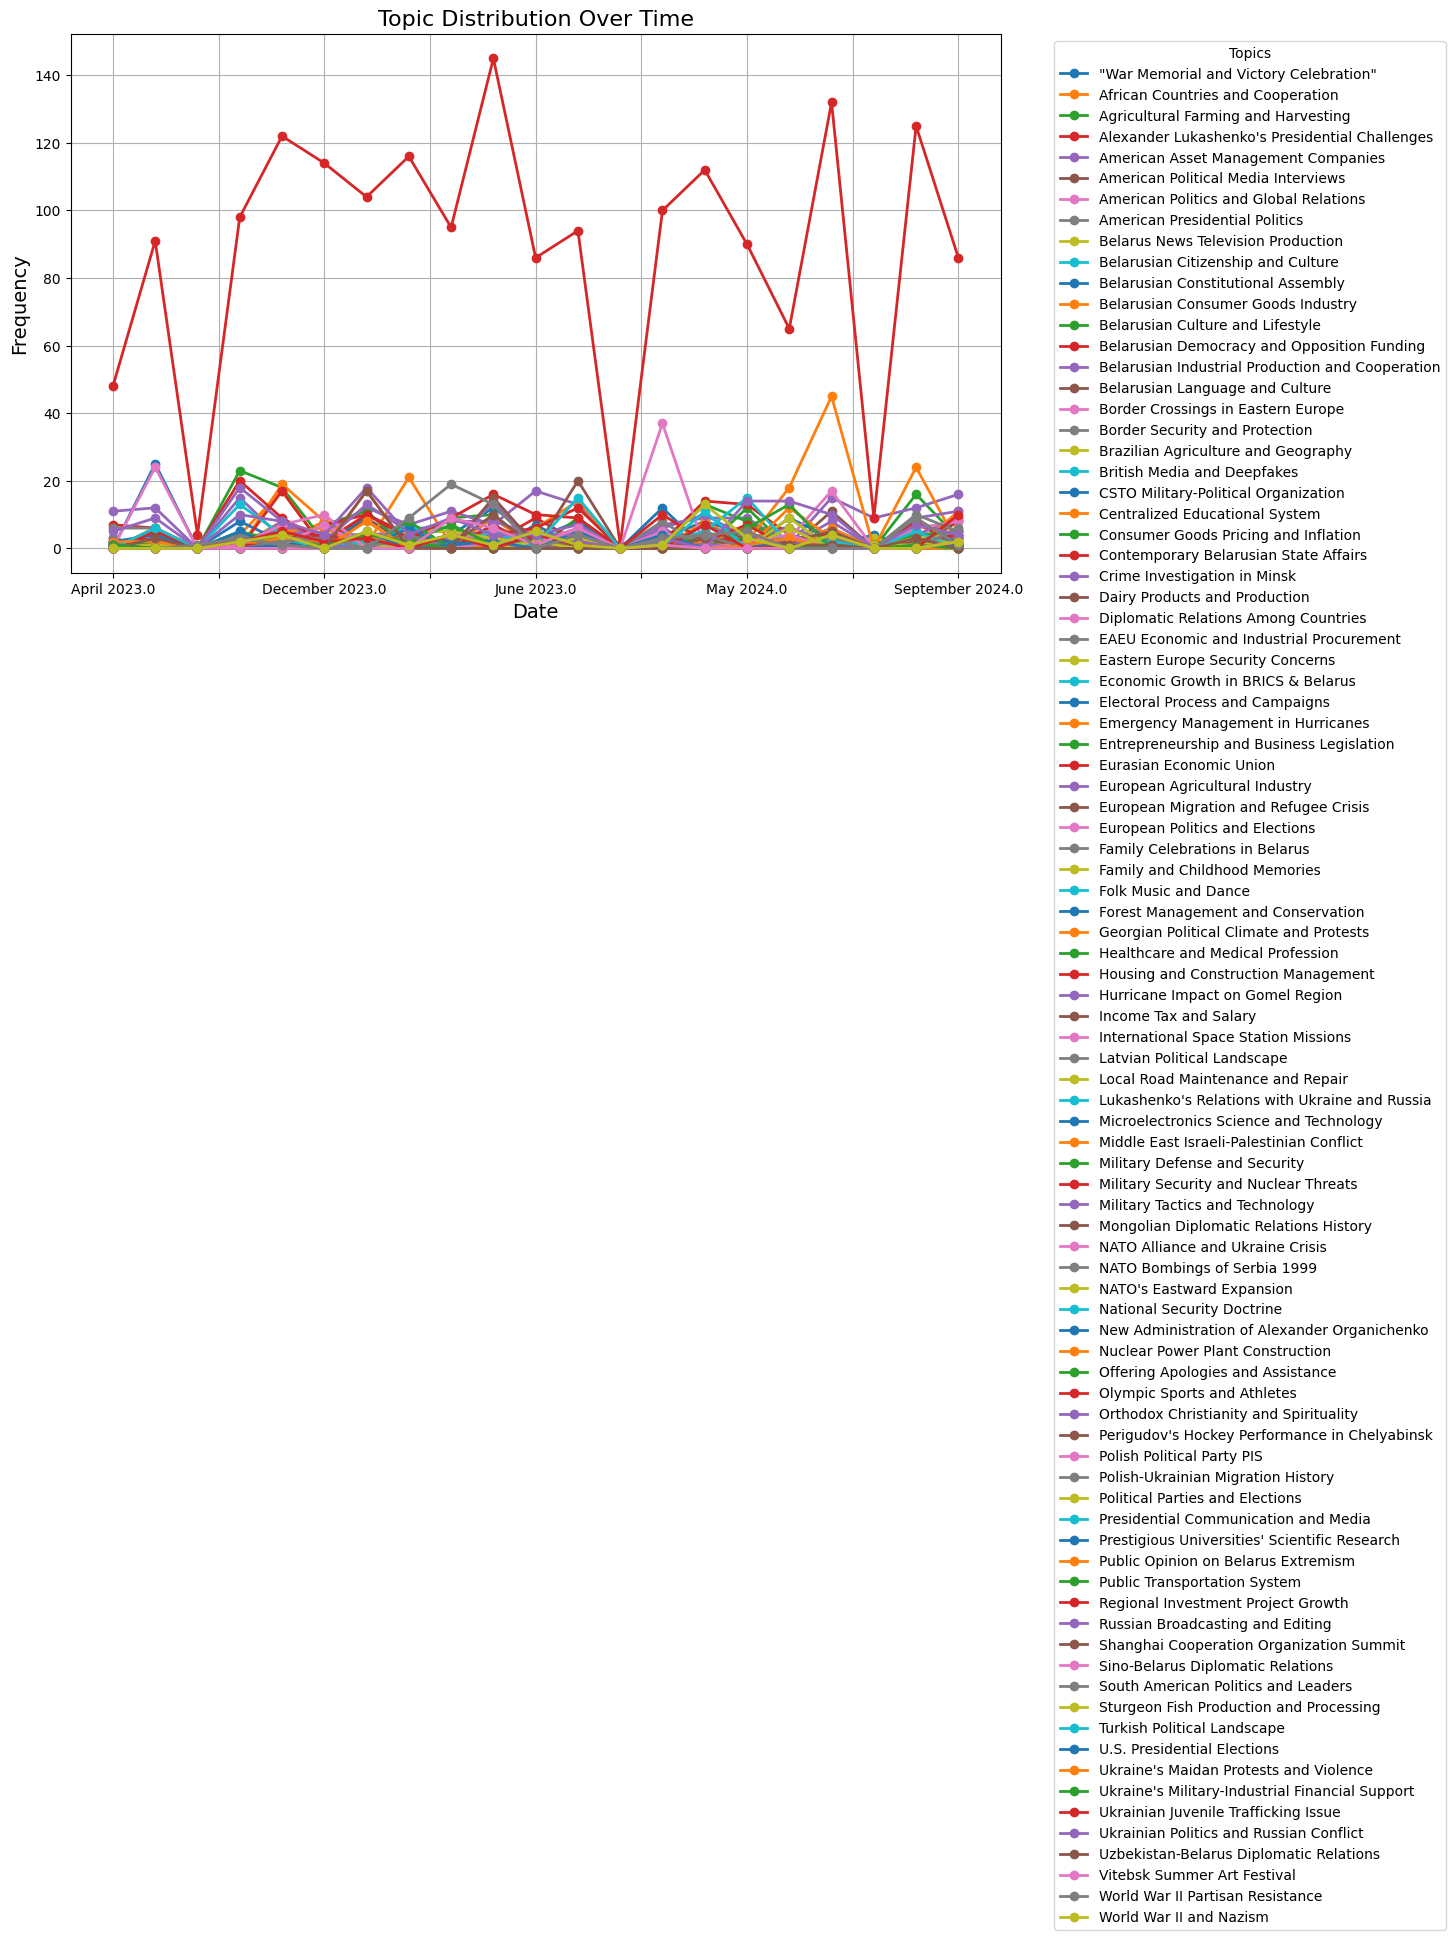

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by date and topic name to calculate frequency
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'Assigned_Topic_Name'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='Assigned_Topic_Name', values='Frequency').fillna(0)
pivoted_data.plot(kind='line', figsize=(12, 7), marker='o', linewidth=2)

plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

## Creating Larger Thematic Groups

In [126]:
# creating larger groups
topic_groups = {
    "Belarusian Internal Politics": [-1, 35, 11, 16, 22, 37, 44, 56, 16, 63, 72, 70, 86],
    "Belarusian Economics and Development": [0, 4, 8, 10, 12, 39, 45, 46, 66, 76, 77, 87],
    "Belarusian Culture": [7, 13, 20, 28, 32, 38, 40, 41, 43, 54, 55, 59, 60, 65, 67, 71],
    "US-Related Politics": [21, 34, 48, 49, 52, 64, 78, 85], # 80 is british
    "World War II-Related Topics": [9, 15, 19],
    "Sports": [2, 69],
    "Belarusian Regional and International Cooperation": [6, 23, 25, 29, 31, 33, 30, 50, 61, 73, 81, 82],
    "Russian War on Ukraine": [1, 3, 24, 27, 53, 74, 83],
    "Global Politics": [5, 42, 51, 75, 79],
    "European Politics and Migration": [14, 17, 26, 36, 47, 57, 58, 62, 68, 80, 84], # 80 here
}

In [127]:
def assign_group(topic_id):
    """
    Assigns a group name based on the given topic ID by checking predefined topic groups.

    This function iterates over a dictionary called `topic_groups`, where each key is a group name and each value 
    is a list of topic IDs. If the provided topic_id is found in one of the groups, the corresponding group name is returned.
    If the topic_id is not found in any group, it returns "Other".

    Parameters:
        topic_id (Any): The identifier for a topic, which is compared against the lists in `topic_groups`.

    Returns:
        str: The name of the group to which the topic_id belongs, or "Other" if no match is found.
    """
    for group, ids in topic_groups.items():
        if topic_id in ids:
            return group
    return "Other"

exploded_data_for_modeling["New Group"] = exploded_data_for_modeling["Assigned_Topic_ID"].apply(assign_group)
exploded_data_for_modeling = exploded_data_for_modeling[exploded_data_for_modeling["Group"] != "Other"]

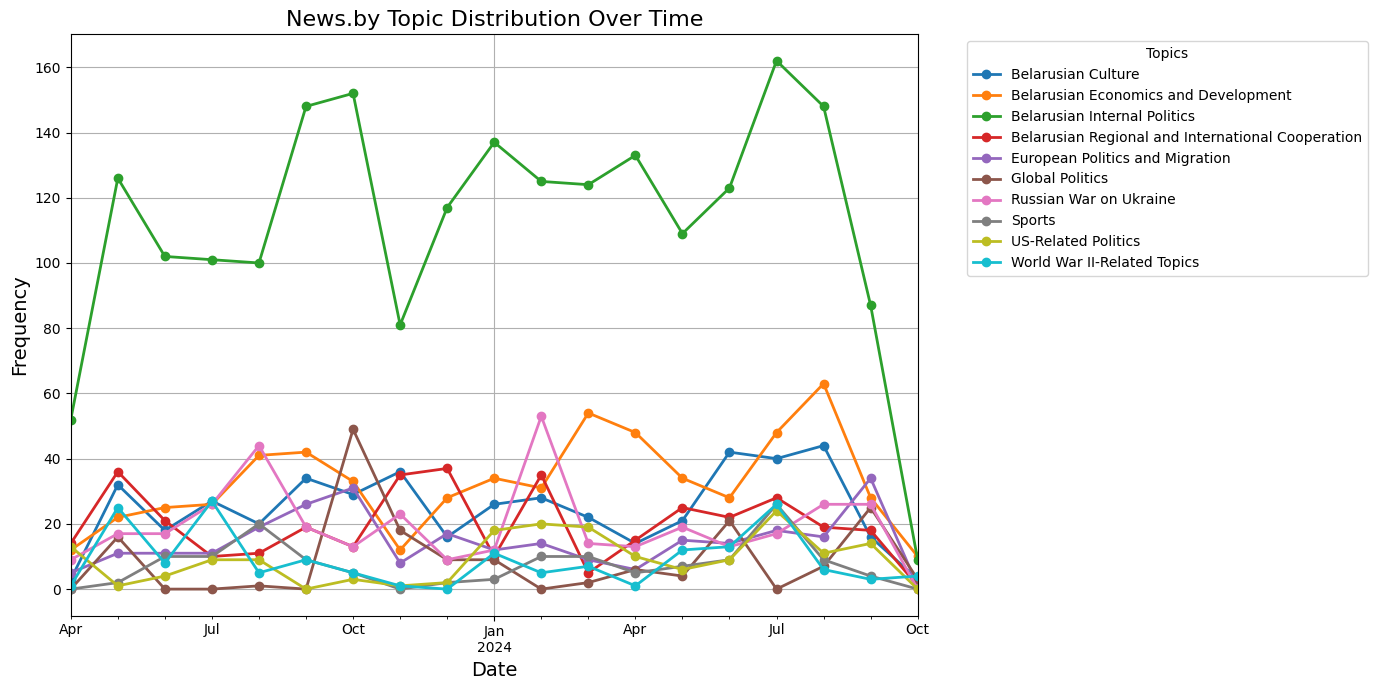

In [99]:
# Grouping by date and topic name to calculate frequency of topic groups
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'New Group'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='New Group', values='Frequency').fillna(0)
pivoted_data.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)

plt.title('News.by Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
from scipy.special import softmax
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [291]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to calculate sentiment scores for a single text
def get_sentiment_scores(text):
    """
    Calculates sentiment scores for a given text using a pre-trained sentiment analysis model.

    The function tokenizes the input text, feeds it into the model to obtain raw output, applies a softmax
    to convert the outputs into probability scores, and then maps these scores to their corresponding sentiment
    labels as defined in `config.id2label`.

    Parameters:
        text (str): The input text for which sentiment analysis is to be performed.

    Returns:
        dict: A dictionary mapping sentiment labels (e.g., "positive", "neutral", "negative") to their respective
              probability scores. In case of an error during processing, it prints an error message and returns
              a dictionary with sentiment values set to None.
    """
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        scores = softmax(output[0][0].detach().numpy())
        return {config.id2label[i]: scores[i] for i in range(len(scores))}
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {"positive": None, "neutral": None, "negative": None}

tqdm.pandas()
exploded_data_for_modeling['Sentiment_Scores'] = exploded_data_for_modeling['Processed_Chunks'].progress_apply(get_sentiment_scores)

# Extracting scores into separate columns
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('positive'))
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('neutral'))
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('negative'))
exploded_data_for_modeling.drop(columns=['Sentiment_Scores'], inplace=True)

print(exploded_data_for_modeling.head())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████| 4908/4908 [10:46<00:00,  7.59it/s]


            Date                                             Chunks  \
0  August 2022.0  MUSICAL INTRO Belarus celebrates Independence ...   
1  August 2022.0  about their desires. They had a set goal of de...   
2  August 2022.0  hunt for her and her family. This is what a wo...   
3  August 2022.0  my results from the criminal investigation est...   
4  August 2022.0  War. The memory of the Great Patriotic War is ...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  MUSICAL INTRO Belarus celebrates Independence ...                 -1   
1  desires. set goal destroying local Belarusian ...                 -1   
2  hunt family. woman, seen life, says Nazism. un...                 -1   
3  results criminal investigation established 198...                  9   
4  War. memory Great Patriotic War safeguard Bela...                 -1   

                     Assigned_Topic_Name                         Group  \
0  Contemporary Belarusian State Affairs  Belaru

In [280]:
# Storing the final sentiment into a separate column
exploded_data_for_modeling['Final_Sentiment'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].idxmax(axis=1)
exploded_data_for_modeling['Final_Sentiment_Score'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].max(axis=1)
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Positive_Score' else 0, axis=1)
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Neutral_Score' else 0, axis=1)
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Negative_Score' else 0, axis=1)

In [118]:
exploded_data_for_modeling.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/sentiment_dataset.csv')

In [160]:
exploded_data_for_modeling['Date'] = exploded_data_for_modeling['Date'].dt.to_datetime()
exploded_data_for_modeling['Quarter'] = exploded_data_for_modeling['Date'].dt.to_period('Q')
grouped_sentiment['Quarter'] = exploded_data_for_modeling['Quarter'].dt.start_time
grouped_sentiment = exploded_data_for_modeling.groupby(['New Group'])[['Positive_Score', 'Neutral_Score', 'Negative_Score']].mean().reset_index()

### Sentiment Analysis: Visualisation

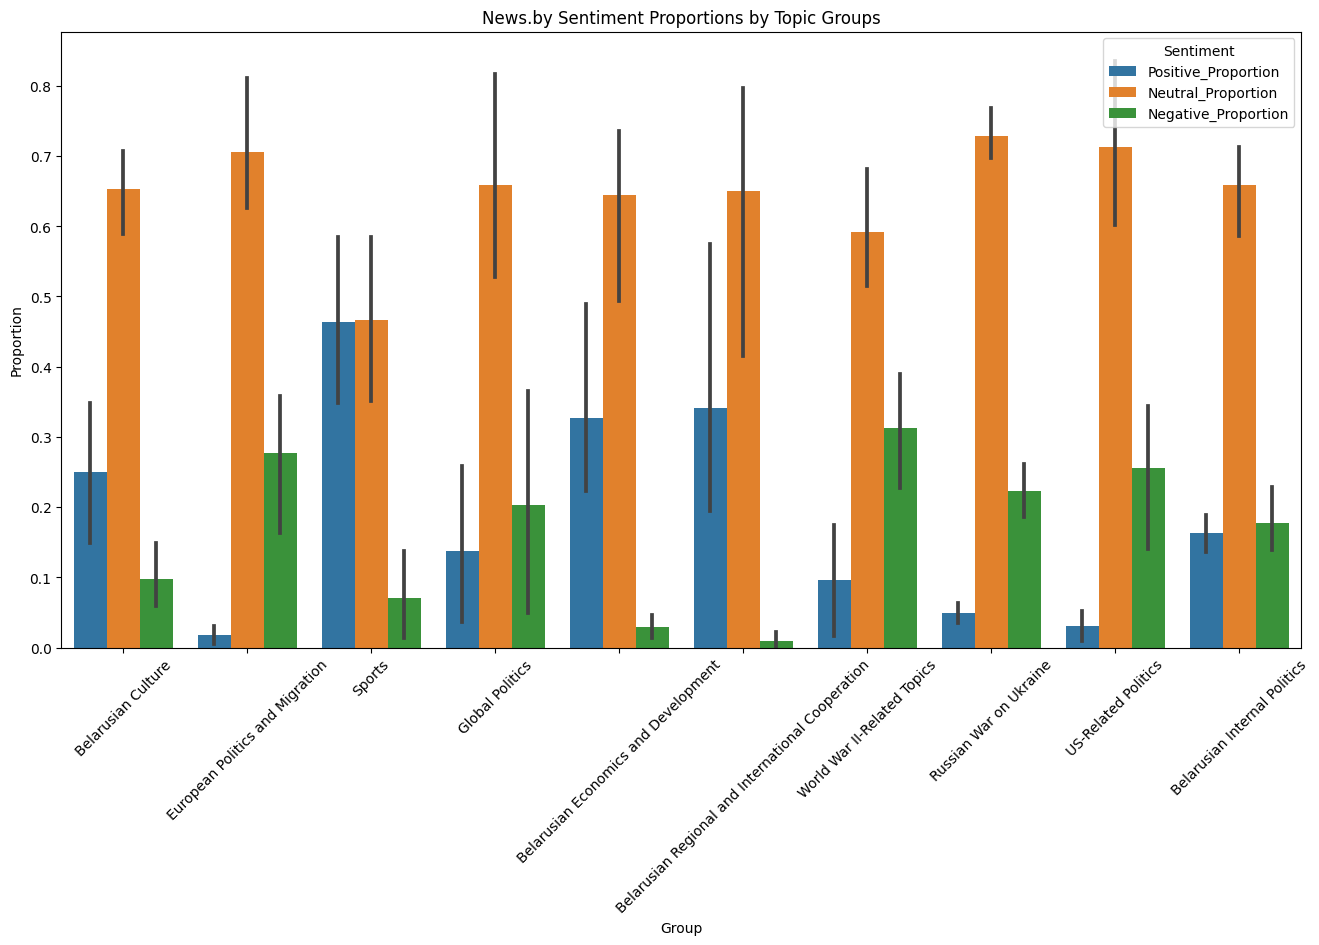

In [179]:
# Plotting Sentiment proportions by topic groups
grouped_sentiment_long = grouped_sentiment.melt(
    id_vars=['New Group'], 
    value_vars=['Positive_Proportion', 'Neutral_Proportion', 'Negative_Proportion'],
    var_name='Sentiment', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(data=grouped_sentiment_long, x='New Group', y='Proportion', ax=ax, hue='Sentiment')
plt.title('News.by Sentiment Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Sentiment')
plt.show()

### Summary Table: Sentiment Proportions by Group

In [186]:
selected_topics = ["Sports", "Russian War on Ukraine", "US-Related Politics", "Belarusian Internal Politics"]
filtered_data = grouped_sentiment[grouped_sentiment['New Group'].isin(selected_topics)]

# Computing the averages
sentiment_averages = filtered_data.groupby('New Group')[
    ['Positive_Proportion','Negative_Proportion', 'Neutral_Proportion']
].mean().reset_index()

news_by_metrics = sentiment_averages

In [187]:
news_by_metrics

,New Group,Positive_Proportion,Negative_Proportion,Neutral_Proportion
0,Belarusian Internal Politics,0.163745,0.177392,0.658863
1,Russian War on Ukraine,0.048809,0.222764,0.728427
2,Sports,0.463464,0.069909,0.466627
3,US-Related Politics,0.030930,0.255942,0.713129


In [188]:
news_by_metrics = news_by_metrics.rename(columns={
    'Positive_Proportion': 'Positive Sentiment',
    'Negative_Proportion': 'Negative Sentiment',
    'Neutral_Proportion': 'Neutral Sentiment'
})

In [189]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/new_analyses/bel_summary_table_sentiment.csv')

## Emotion Analysis

In [31]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Load the emotion classifier
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Define a function to classify emotions and extract scores
def classify_emotions(text):
    """
    Classifies the emotions in a given text and extracts corresponding sentiment scores.

    This function uses a pre-trained emotion classifier to analyze the input text and returns a dictionary 
    mapping emotion labels (e.g., "joy", "anger", etc.) to their respective scores. The scores represent 
    the classifier's confidence in each emotion. In case of an error during processing, the function prints 
    an error message and returns an empty dictionary.

    Parameters:
        text (str): The input text to be analyzed for emotional content.

    Returns:
        dict: A dictionary where keys are emotion labels and values are their corresponding scores. 
              Returns an empty dictionary if an error occurs.
    """
    try:
        results = classifier(text)
        scores = {result['label']: result['score'] for result in results[0]}
        return scores
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {}

tqdm.pandas()
emotion_analysis_data['Emotion_Scores'] = emotion_analysis_data['Processed_Chunks'].progress_apply(classify_emotions)

# Splitting the Emotion_Scores into separate columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
for emotion in emotion_columns:
    emotion_analysis_data[f'{emotion}_score'] = emotion_analysis_data['Emotion_Scores'].apply(lambda x: x.get(emotion, None))

emotion_analysis_data.drop(columns=['Emotion_Scores'], inplace=True)
print(emotion_analysis_data.head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
 94%|████████████████████████████████████▋  | 4613/4908 [06:00<00:20, 14.16it/s]

Error processing text: Editor subtitles A. Sinyetskaya Proofreader A. Kul... - The expanded size of the tensor (605) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 605].  Tensor sizes: [1, 514]


100%|███████████████████████████████████████| 4908/4908 [06:23<00:00, 12.80it/s]


         Date                                             Chunks  \
0  2022-08-01  MUSICAL INTRO Belarus celebrates Independence ...   
1  2022-08-01  about their desires. They had a set goal of de...   
2  2022-08-01  hunt for her and her family. This is what a wo...   
3  2022-08-01  my results from the criminal investigation est...   
4  2022-08-01  War. The memory of the Great Patriotic War is ...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  MUSICAL INTRO Belarus celebrates Independence ...                 -1   
1  desires. set goal destroying local Belarusian ...                 -1   
2  hunt family. woman, seen life, says Nazism. un...                 -1   
3  results criminal investigation established 198...                  9   
4  War. memory Great Patriotic War safeguard Bela...                 -1   

                     Assigned_Topic_Name                         Group  \
0  Contemporary Belarusian State Affairs  Belarusian Internal Poli

In [32]:
# Creating a separate column for the final emotion (highest score)
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)
emotion_analysis_data['Final_Emotion_Score'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].max(axis=1)
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data['Final_Emotion'].str.replace('_score', '', regex=False)

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68862/1450040514.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)


In [206]:
emotion_analysis_data.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/emotion_dataset_new.csv")

### Visualising the Emotion scores per topic group

In [265]:
# Grouping by topic
grouped_emotion = emotion_analysis_data.groupby(['New Group'])[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].mean().reset_index()

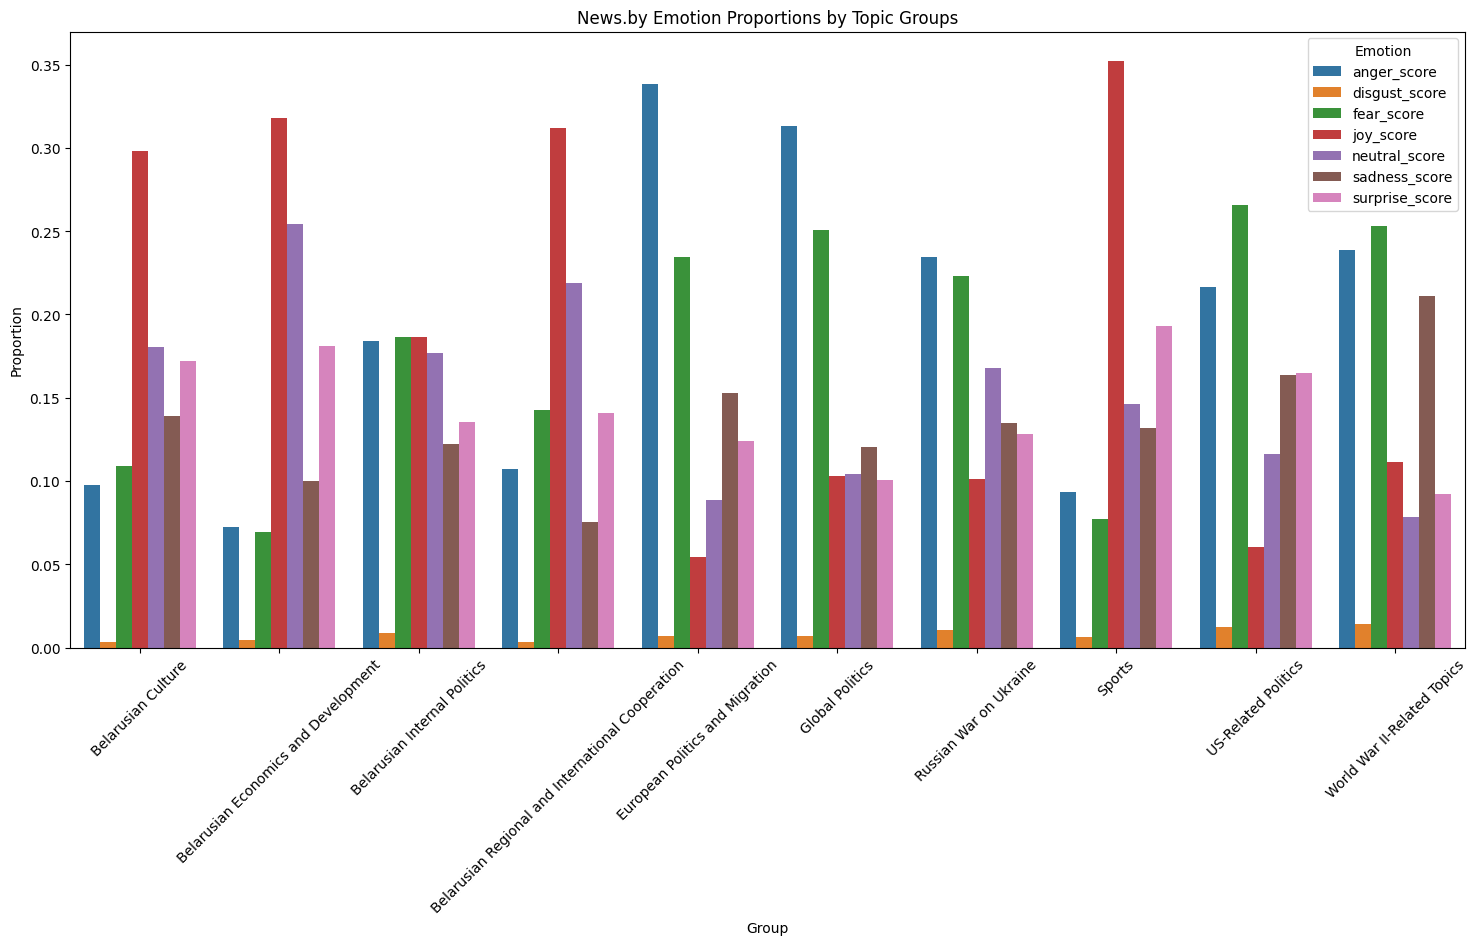

In [253]:
# Plotting the bar chart of every topic group and emotion
grouped_emotion_long = grouped_emotion.melt(
    id_vars=['New Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='New Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('News.by Emotion Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

### Emotion Analysis over time (Quarterly)

In [1]:
bel_emotion = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/emotion_dataset_new.csv")

In [2]:
# Creating Quarters
bel_emotion['Date'] = pd.to_datetime(bel_emotion['Date'], errors='coerce')
bel_emotion['Year'] = bel_emotion['Date'].dt.year
bel_emotion['Month'] = bel_emotion['Date'].dt.month_name()
bel_emotion = bel_emotion.query("Year != 2022") 
bel_emotion['Quarter'] = bel_emotion['Date'].dt.to_period('Q')
bel_emotion['Quarter'] = bel_emotion['Quarter'].dt.start_time

In [3]:
# Keeping only the needed topics since the visualisation above is crowded
grouped_emotion = bel_emotion.groupby(['New Group'])[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].mean().reset_index()
topics_to_keep = ["Belarusian Internal Politics", "US-Related Politics", "Russian War on Ukraine", 'Sports']
grouped_emotion_filtered = grouped_emotion[grouped_emotion['New Group'].isin(topics_to_keep)]

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

emotion_columns = ["anger_Proportion", "fear_Proportion", "joy_Proportion"]

# Ensure 'Quarter' is in datetime format and then convert to "YYYY-QN" format
grouped_emotion_filtered['Quarter'] = pd.to_datetime(grouped_emotion_filtered['Quarter'])
grouped_emotion_filtered['Quarter_Label'] = grouped_emotion_filtered['Quarter'].dt.to_period('Q').astype(str)

fig, axes = plt.subplots(len(topics_to_keep), 1, figsize=(14, 10), sharex=True)
if len(topics_to_keep) == 1:
    axes = [axes]

for i, topic in enumerate(topics_to_keep):
    topic_data = grouped_emotion_filtered[grouped_emotion_filtered['New Group'] == topic].copy()

    # Set the x-axis labels explicitly
    if not topic_data.empty:
        topic_data.set_index('Quarter', inplace=True)  # Keep DateTimeIndex for correct sorting
        topic_data[emotion_columns].plot(kind='line', ax=axes[i], marker='o', linewidth=2)
        
        # Manually set x-axis labels
        axes[i].set_xticks(topic_data.index)
        axes[i].set_xticklabels(topic_data['Quarter_Label'], rotation=45, fontsize=10, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f"No data for {topic}", ha='center', va='center', fontsize=12, color='red')

    axes[i].set_title(f'News.by Emotion Proportions Over Time: {topic}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)

plt.xlabel('Quarter', fontsize= 12)
for ax in axes:
    ax.legend(title='Emotions', loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("news_by_emotions_quarterly_by_topic.png", dpi=300, bbox_inches='tight')
plt.show()

## Emotion Analysis for Opposition subtopics

Here, I am investigating the subtopics of "Belarusian Internal Politics" further. For this purpose, I chose to focus on two subtopics that are related to opposition: Belarusian Democracy and Opposition Funding and Public Opinion on Belarus Extremism. 

In [5]:
# Selecting two subtopics for further investigation
# 22: Belarusian Democracy and Opposition Funding
# 35: Public Opinion on Belarus Extremism
opposition_df = bel_emotion[bel_emotion["Assigned_Topic_ID"].isin([22, 35])]
opposition_df['Quarter'] = pd.to_datetime(opposition_df['Quarter'])
opposition_df['Quarter_Label'] = opposition_df['Quarter'].dt.to_period('Q').astype(str)

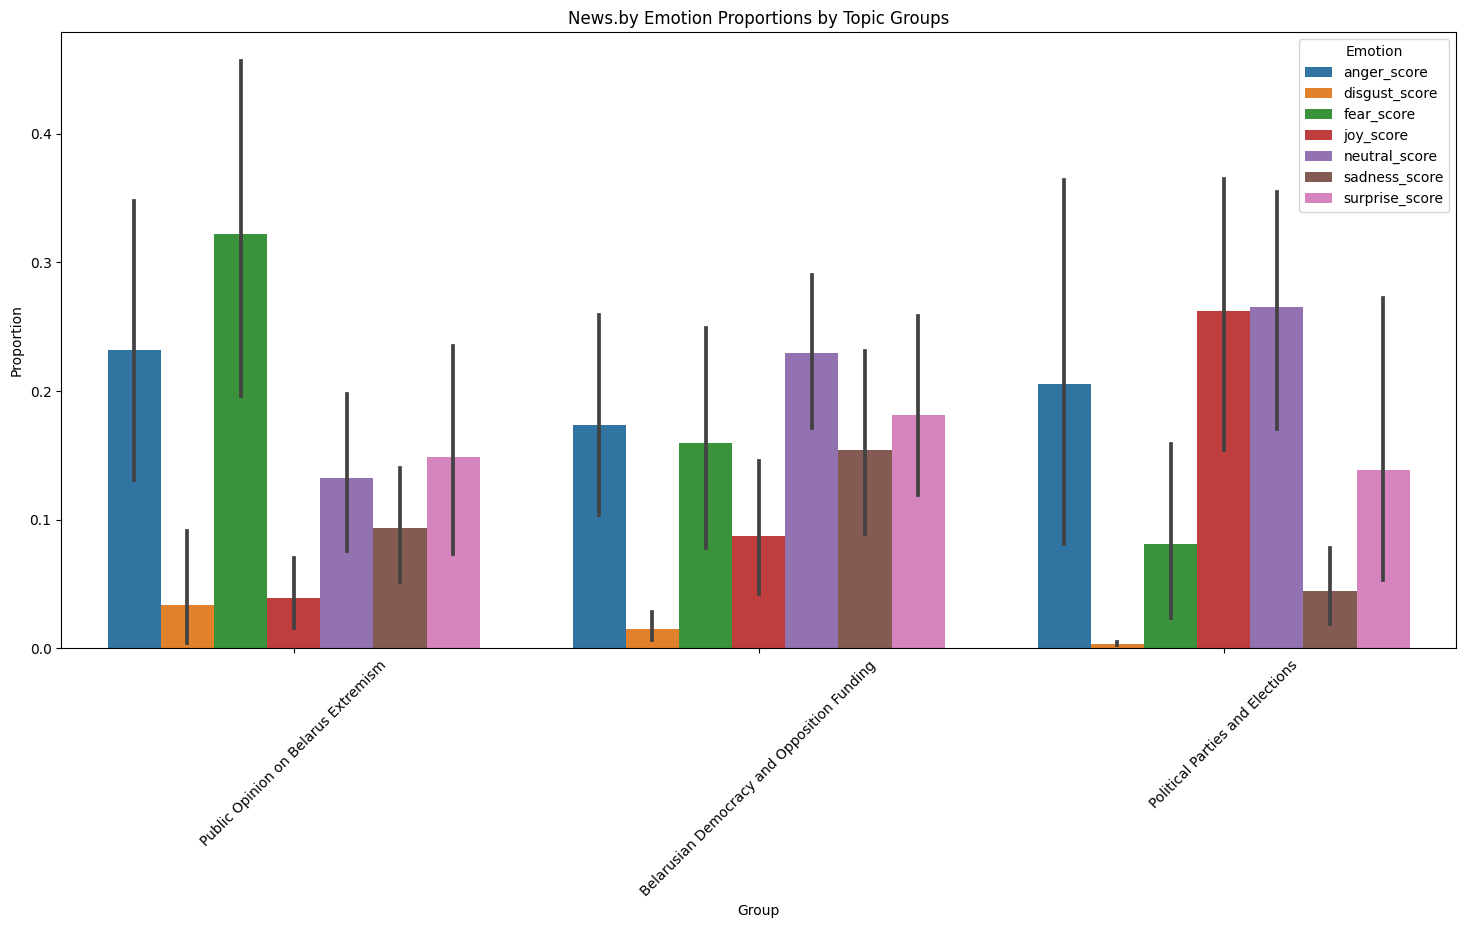

In [283]:
# Exploring three subtopics within the Belarusian Internal Politics group
grouped_emotion_long = opposition_df.melt(
    id_vars=['Assigned_Topic_Name'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Assigned_Topic_Name', y='Proportion', ax=ax, hue='Emotion')
plt.title('News.by Emotion Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

The code below plots the distribution of emotion scores within the two subtopics of Belarusian Internal Politics over time (Quarterly).

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define emotion score columns
emotion_columns = ["anger_score", "fear_score", "joy_score"]

# Convert Quarter_Label into a sortable format (e.g., 2024Q1 → period "2024Q1")
opposition_df["Quarter_Sort"] = pd.PeriodIndex(opposition_df["Quarter_Label"], freq="Q")

# Get unique topic names
topics = opposition_df["Assigned_Topic_Name"].unique()

# Create subplots (one for each topic)
fig, axes = plt.subplots(len(topics), 1, figsize=(14, 10), sharex=True)

# Ensure axes is always iterable (for a single topic case)
if len(topics) == 1:
    axes = [axes]

# Loop through each topic and plot separately
for i, topic in enumerate(topics):
    topic_data = opposition_df[opposition_df["Assigned_Topic_Name"] == topic].copy()

    # Sort by Quarter_Sort (ensures correct order: 2024Q1 < 2024Q2 < 2024Q3)
    topic_data.sort_values(by="Quarter_Sort", inplace=True)

    # Melt data for Seaborn
    melted_data = topic_data.melt(id_vars=["Quarter_Label"], 
                                  value_vars=emotion_columns, 
                                  var_name="Emotion", 
                                  value_name="Proportion")

    # Plot using Seaborn
    sns.lineplot(data=melted_data, x="Quarter_Label", y="Proportion", 
                 hue="Emotion", marker="o", ax=axes[i])

    # Set subplot title
    axes[i].set_title(f'Emotion Proportions Over Time: {topic}', fontsize=14)

    # Set grid and labels
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)
    axes[i].legend(title="Emotion")

# Set x-axis labels only on the last subplot
axes[-1].set_xticklabels(sorted(opposition_df["Quarter_Label"].unique(), key=lambda x: pd.Period(x, freq="Q")), 
                         rotation=45, fontsize=10, fontweight="bold")
axes[-1].set_xlabel("Quarter", fontsize=12)

plt.tight_layout()
plt.savefig("news_by_emotions_monthly_subtopics.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Define emotion score columns
emotion_columns = ["anger_score", "fear_score", "joy_score"]
# Calculate mean emotion scores for each topic
average_emotions = opposition_df.groupby("Assigned_Topic_Name")[emotion_columns].mean().reset_index()
average_emotions.to_csv("average_emotion_opposition.csv")

In [8]:
# Counting the total number of samples for each topic
topic_counts = opposition_df['Assigned_Topic_Name'].value_counts()
print("Total number of samples per topic:")
print(topic_counts)